In [1]:
from SleepInference.SleepInferenceAPI import SleepInferenceAPI, SleepDetector
from SleepInference.SleepPreprocessor import SleepPreprocessor
from SleepInference.TimeSeriesDecomposition import Decomposer
from Utils import City, AggregationLevel, TrafficType
from DataIO import DataIO
from IrisAggregation.GeoData import IrisGeoData, TileGeoData
import geopandas as gpd
import plotly.graph_objects as go
import pandas as pd
from statsmodels.tsa.seasonal import MSTL, STL
from statsmodels.tsa.seasonal import DecomposeResult
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from config import TEMP_DATA_PATH

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
city = City.LYON
aggregation_level = AggregationLevel.IRIS
xar_city = DataIO.load_traffic_data(city=city, traffic_type=TrafficType.B, aggregation_level=aggregation_level)

100%|██████████| 77/77 [00:47<00:00,  1.61it/s]


In [4]:
preprocessor = SleepPreprocessor(xar_city=xar_city, city=city)
time_series_data = preprocessor.preprocess()

In [5]:
time_series_data.head()

iris                        11050000   12380000   12480000   12490101   \
day        time                                                          
2019-03-16 0 days 00:00:00   299627.0   262897.0   146285.0   194888.0   
           0 days 00:15:00   302568.0   294696.0   170839.0   194158.0   
           0 days 00:30:00   632095.0   339727.0   210722.0   193170.0   
           0 days 00:45:00   306368.0   223627.0   210193.0   158586.0   
           0 days 01:00:00   220132.0   203480.0   175046.0   149113.0   

iris                        12490103   12750000   12760000   13220000   \
day        time                                                          
2019-03-16 0 days 00:00:00   286186.0  1076542.0    11351.0    65080.0   
           0 days 00:15:00   332667.0  1008768.0    19198.0    71788.0   
           0 days 00:30:00   403893.0   945164.0    16615.0    83191.0   
           0 days 00:45:00   327552.0   813457.0    14068.0    39240.0   
           0 days 01:00:00   184755.0   875856.0    11252.0    31901.0   

iris                        13760000   14180000   ...  693890303   693890401  \
day        time                                   ...                          
2019-03-16 0 days 00:00:00   106307.0   483967.0  ...  6412514.0  20671380.0   
           0 days 00:15:00    99161.0   482205.0  ...  7150881.0  20385820.0   
           0 days 00:30:00    90080.0   445733.0  ...  6606154.0  19349253.0   
           0 days 00:45:00    78584.0   437453.0  ...  5093367.0  17863549.0   
           0 days 01:00:00    69631.0   330389.0  ...  6113946.0  23949874.0   

iris                         693890402   693890403   693890501   693890502  \
day        time                                                              
2019-03-16 0 days 00:00:00  26981890.0  12247350.0   7667614.0  13319968.0   
           0 days 00:15:00  29876853.0  12326986.0   7684855.0  13278141.0   
           0 days 00:30:00  29404898.0  11183489.0   7524622.0  12805314.0   
           0 days 00:45:00  21068697.0   9852309.0   9078735.0  12019984.0   
           0 days 01:00:00  19329793.0  16059427.0  11015903.0  16420533.0   

iris                        693890604  693890605  693890606  693890607  
day        time                                                         
2019-03-16 0 days 00:00:00  3554865.0  4724878.0  8205376.0  2337918.0  
           0 days 00:15:00  3522776.0  4779325.0  8876240.0  2355854.0  
           0 days 00:30:00  3566642.0  4625816.0  8128773.0  2353098.0  
           0 days 00:45:00  2225675.0  3170158.0  6549554.0  1602625.0  
           0 days 01:00:00  4267039.0  4483452.0  8462154.0  2877920.0  

[5 rows x 556 columns]

In [6]:
decomposer = Decomposer(time_series_data=time_series_data)
res = decomposer.decompose()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 420 tasks      | elapsed: 57.1min
[Parallel(n_jobs=-1)]: Done 556 out of 556 | elapsed: 74.7min finished


In [16]:
df = pd.read_csv(f'{TEMP_DATA_PATH}/SeasonalDec/{11050000}.csv')
df.head()

,day,time,seasonal_day,seasonal_week,observed,trend,residuals
0,2019-03-16,0 days 00:00:00,-211685.403928,98620.350529,299627.0,426214.380217,-13522.326818
1,2019-03-16,0 days 00:15:00,-124645.443586,56619.695105,302568.0,426124.629659,-55530.881177
2,2019-03-16,0 days 00:30:00,-198526.309616,61397.358745,632095.0,426034.889682,343189.061189
3,2019-03-16,0 days 00:45:00,-249089.609570,76255.410846,306368.0,425945.160385,53257.038338
4,2019-03-16,0 days 01:00:00,-272658.227915,19843.284098,220132.0,425855.441859,47091.501958


In [17]:
len(time_series.columns)

556

In [5]:
ts_iris = [time_series.T.iloc[i] for i in [7, 270, 450]]

In [14]:
from statsmodels.tsa.seasonal import MSTL, STL
from statsmodels.tsa.seasonal import DecomposeResult
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [18]:
register_matplotlib_converters()
sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

In [ ]:
periods = [96, 96*7]
windows = [96 + 1, 96*7+ 1]

In [9]:
res = []
for ts in ts_iris:
    mstl = MSTL(ts, periods=periods, windows=windows, stl_kwargs={'robust': True})
    res.append(mstl.fit())

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
r = res[0]
r.trend

2019-03-16 00:00:00    2.059917e+07
2019-03-16 00:15:00    2.059626e+07
2019-03-16 00:30:00    2.059335e+07
2019-03-16 00:45:00    2.059044e+07
2019-03-16 01:00:00    2.058753e+07
                           ...     
2019-05-31 22:45:00    1.674256e+07
2019-05-31 23:00:00    1.673806e+07
2019-05-31 23:15:00    1.673357e+07
2019-05-31 23:30:00    1.672907e+07
2019-05-31 23:45:00    1.672458e+07
Name: trend, Length: 7392, dtype: float64

In [ ]:
r

<AxesSubplot:>

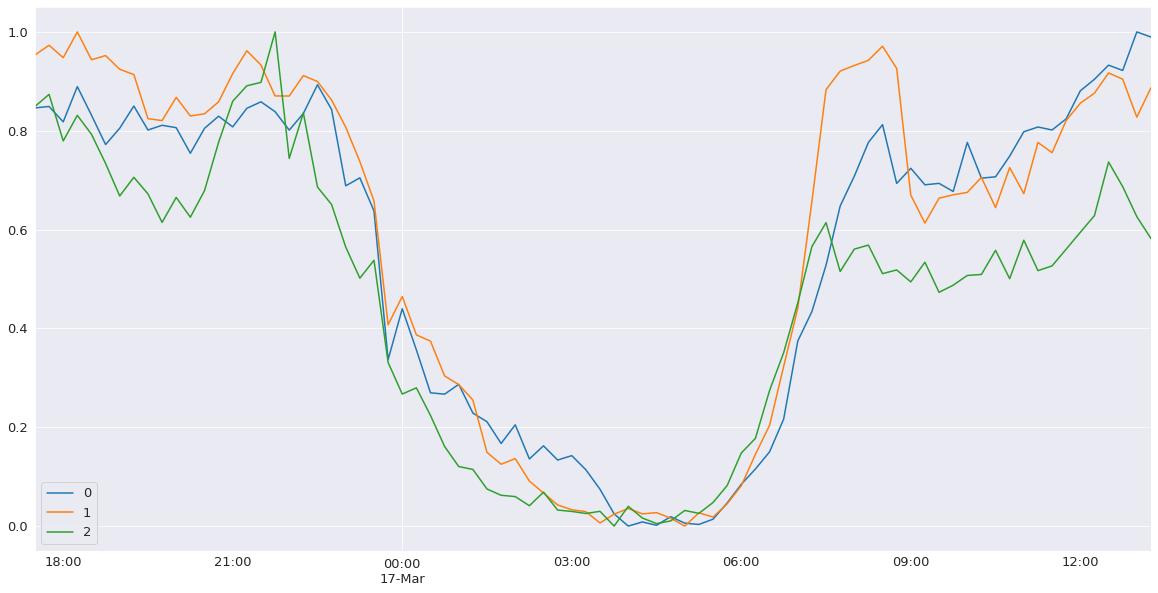

In [26]:
data = []
index = None
a = 70
b = 150
for r in res:
    scaler = MinMaxScaler()
    index = r.seasonal.index[a:b]
    data.append(scaler.fit_transform(r.seasonal['seasonal_96'].iloc[a:b].values.reshape(-1,1)).flatten())
data = pd.DataFrame(np.array(data).T, index=index)
data.plot(figsize=(20,10))

In [27]:
plt.close()

<AxesSubplot:xlabel='time'>

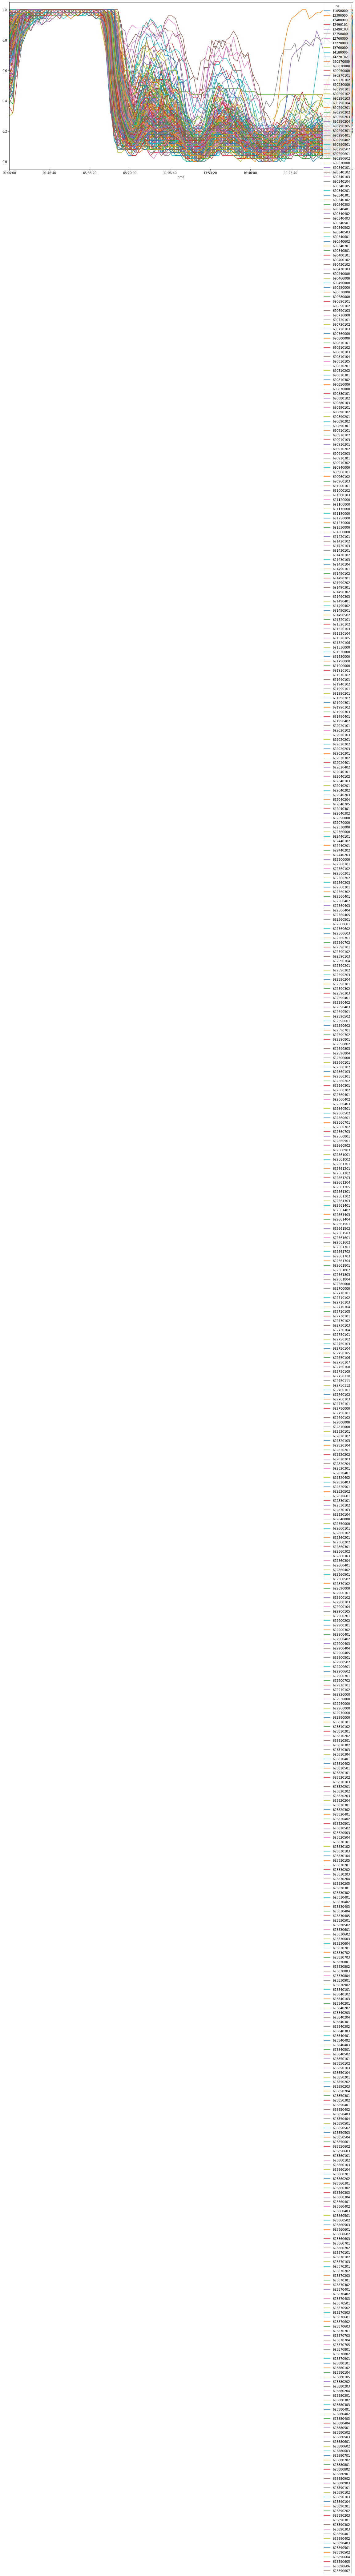

In [13]:
avg_sleep_lyon3.T.plot(figsize=(20,10))

In [5]:
avg_sleep_lyon = sleep_lyon.mean('day')

In [31]:
sleep = (avg_sleep_lyon.sum(axis=1) / 4).to_frame()
sleep.index = [str(a) for a in sleep.index]
sleep.columns = ['sleep']

In [39]:
sleep_geo = gpd.GeoDataFrame(sleep.merge(geo_data, left_index=True, right_index=True))

<AxesSubplot:>

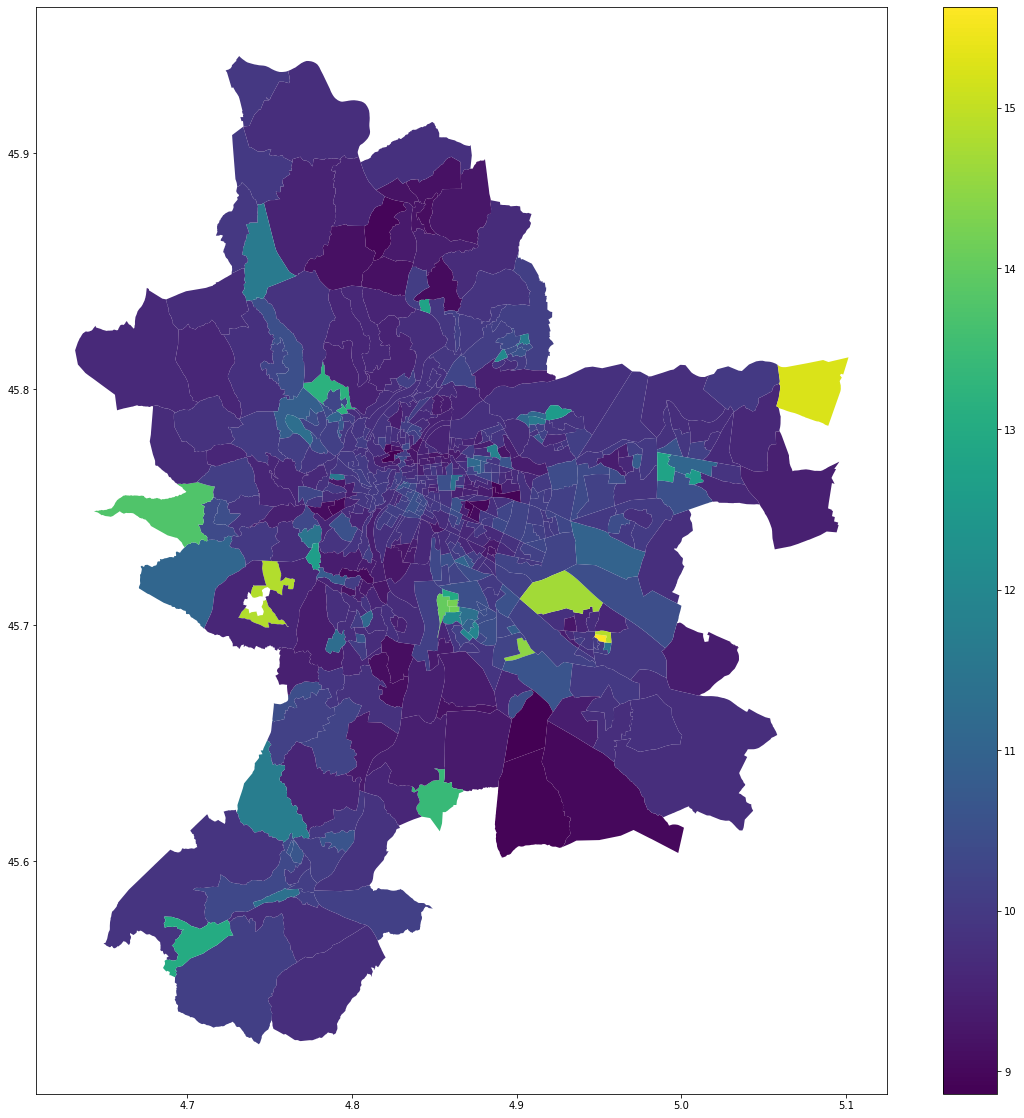

In [41]:
sleep_geo.plot(column="sleep", figsize=(20,20), legend=True)

In [26]:
geo_data.index

Index(['290460101', '291580101', '290190123', '290460106', '290460102',
       '290190160', '291580102', '330630303', '290460107', '290190158',
       ...
       '674430000', '672610000', '453070000', '452870000', '211830000',
       '214520000', '542800000', '602090000', '600540000', '393780000'],
      dtype='object', name='CODE_IRIS', length=48590)